# 대회 개요


## 주제
- 공기압축기 이상 판단(제4회 2023 연구개발특구 AI SPARK 챌린지)
- 산업기기 피로도를 예측하는 문제

## 모델 조건
- 모델링은 비지도학습 방식으로 진행
- 입력된 데이터를 정상(0), 이상(1)로 구분하는 이진 분류 모델
- 시간 단위로 생성되는 입력 데이터에 대하여 판정을 수행할 수 있는 모델
- 신규 데이터로 학습/개선이 가능한 모델
- 외부 공공 데이터 사용 가능

## 기타 중요 내용
- 반드시 리더보드상의 순위 기록에 해당되는 버전의 코드/모델 가중치를 제출
- 소스코드 내의 모든 무작위성은 seed 설정을 통해 통제

# 데이터 불러오기

* train_data
    * 학습용 데이터 
    * 모두 정상 case로 이루어짐
    * (2463 * 8)
* test_data
    * 평가용 데이터
    * 정상 case와 이상 case가 함께 포함됨
    * (7389 * 8)

* 구성
    - air_inflow: 공기 흡입 유량 (^3/min)
    - air_end_temp: 공기 말단 온도 (°C)
    - out_pressure: 토출 압력 (Mpa)
    - motor_current: 모터 전류 (A)
    - motor_rpm: 모터 회전수 (rpm)
    - motor_temp: 모터 온도 (°C)
    - motor_vibe: 모터 진동 (mm/s)
    - type: 설비 번호
        - 설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)
        - 설비 번호 1: 20HP
        - 설비 번호 2: 10HP
        - 설비 번호 3: 50HP


In [36]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
train_data7 = pd.read_csv("https://raw.githubusercontent.com/only-juun/AI_spark_challenge/main/split_by_type/new_train_data_7.csv", index_col=0)
test_data7 = pd.read_csv("https://raw.githubusercontent.com/only-juun/AI_spark_challenge/main/split_by_type/new_test_data_7.csv", index_col=0)

In [25]:
drop_col = 'type'
train_data7.drop(drop_col, axis=1, inplace=True)
test_data7.drop(drop_col, axis=1, inplace=True)

In [26]:
test_data7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558 entries, 6831 to 7388
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     558 non-null    float64
 1   air_end_temp   558 non-null    float64
 2   out_pressure   558 non-null    float64
 3   motor_current  558 non-null    float64
 4   motor_rpm      558 non-null    float64
 5   motor_temp     558 non-null    float64
 6   motor_vibe     558 non-null    float64
dtypes: float64(7)
memory usage: 34.9 KB


In [27]:
train_data7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186 entries, 2277 to 2462
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     186 non-null    float64
 1   air_end_temp   186 non-null    float64
 2   out_pressure   186 non-null    float64
 3   motor_current  186 non-null    float64
 4   motor_rpm      186 non-null    float64
 5   motor_temp     186 non-null    float64
 6   motor_vibe     186 non-null    float64
dtypes: float64(7)
memory usage: 11.6 KB


# 데이터 전처리

### 데이터 증강

In [28]:
from sklearn.cluster import KMeans

def cluster_based_augmentation(train_data, num_new_data=10000, n_clusters=7):
    # Feature 선택
    # X = train_data[['air_inflow', 'air_end_temp', 'out_pressure', 'motor_current', 'motor_rpm', 'motor_temp', 'motor_vibe', 'type']]
    X = train_data[['air_inflow', 'air_end_temp', 'out_pressure', 'motor_current', 'motor_rpm', 'motor_temp', 'motor_vibe']]
    
    # KMeans 알고리즘을 이용하여 데이터를 클러스터링합니다.
    kmeans = KMeans(n_clusters=n_clusters, n_init=10000, random_state=42).fit(X)

    # 클러스터링 결과 중심점을 centroids에 저장합니다.
    centroids = kmeans.cluster_centers_

    # 각 클러스터의 개수를 저장합니다.
    cluster_sizes = np.bincount(kmeans.labels_)

    # 새로운 데이터를 저장할 빈 리스트를 생성합니다.
    new_data = []

    # 각 클러스터의 중심점을 이용하여 새로운 데이터를 생성합니다.
    for i, centroid in enumerate(centroids):
        for j in range(int(num_new_data * cluster_sizes[i] / len(X))):
            # 중심점 주변에 임의의 값으로 노이즈를 추가합니다.
            new_point = centroid + np.random.normal(scale=0.1, size=len(centroid))
            new_data.append(new_point)

    # 생성된 새로운 데이터를 데이터프레임으로 변환합니다.
    new_data = pd.DataFrame(new_data, columns=X.columns)

    # 기존 데이터와 생성된 데이터를 합쳐서 최종 데이터프레임을 생성합니다.
    final_data = pd.concat([train_data, new_data], ignore_index=True)

    return final_data

In [29]:
new_train_data7 = cluster_based_augmentation(train_data7)
# new_train_data7['type'] = 7
new_train_data7['out_pressure'] = 0.7

In [46]:
new_train_data7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10184 entries, 0 to 10183
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   air_inflow                    10184 non-null  float64
 1   air_end_temp                  10184 non-null  float64
 2   out_pressure                  10184 non-null  float64
 3   motor_current                 10184 non-null  float64
 4   motor_rpm                     10184 non-null  float64
 5   motor_temp                    10184 non-null  float64
 6   motor_vibe                    10184 non-null  float64
 7   air_inflow_per_motor_current  10184 non-null  float64
 8   Discharge_Volume              10184 non-null  float64
 9   air_density                   10184 non-null  float64
dtypes: float64(10)
memory usage: 795.8 KB


### type -> hp(Horse Power)
    * type: 설비 번호
        - 설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)
        - 설비 번호 1: 20HP
        - 설비 번호 2: 10HP
        - 설비 번호 3: 50HP

In [ ]:
mapping_dict = {
    2: 10,
    1: 20,
    0: 30,
    4: 30, 
    5: 30,
    6: 30,
    7: 30,
    3: 50,
}

new_train_data7['hp'] = new_train_data7['type'].map(mapping_dict)
test_data7['hp'] = test_data7['type'].map(mapping_dict)

In [ ]:
new_train_data7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10184 entries, 0 to 10183
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   air_inflow     10184 non-null  float64
 1   air_end_temp   10184 non-null  float64
 2   out_pressure   10184 non-null  float64
 3   motor_current  10184 non-null  float64
 4   motor_rpm      10184 non-null  float64
 5   motor_temp     10184 non-null  float64
 6   motor_vibe     10184 non-null  float64
 7   type           10184 non-null  int64  
 8   hp             10184 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 716.2 KB


### 새로운 Feature 추가하기

In [32]:
# 모터 전류 당 공기 유량은 압축기의 효율성
new_train_data7['air_inflow_per_motor_current'] = new_train_data7['air_inflow'] / new_train_data7['motor_current']	
test_data7['air_inflow_per_motor_current'] = test_data7['air_inflow'] / test_data7['motor_current']

# 압축기와 모터의 상태를 모두 고려한 압축기 효율1
# new_train_data7['Compressor_Efficiency1'] = new_train_data7['out_pressure'] * new_train_data7['air_inflow'] / new_train_data7['motor_current'] / 3.5168 / new_train_data7['hp']
# test_data7['Compressor_Efficiency1'] = test_data7['out_pressure'] * test_data7['air_inflow'] / test_data7['motor_current'] / 3.5168 / test_data7['hp']

# 압축기와 모터의 상태를 모두 고려한 압축기 효율2
# new_train_data7['Motor_Efficiency'] = (new_train_data7['motor_current'] * new_train_data7['motor_rpm'] * new_train_data7['hp']) / (746 * 1000)
# test_data7['Motor_Efficiency'] = (test_data7['motor_current'] * test_data7['motor_rpm'] * test_data7['hp']) / (746 * 1000)

# 압축기의 효율2
# new_train_data7['Compressor_Efficiency2'] = (new_train_data7['out_pressure'] * new_train_data7['air_inflow'] * (new_train_data7['air_end_temp'] - 25)) / (new_train_data7['motor_current'] * new_train_data7['motor_vibe'] * new_train_data7['hp'] * 3.6)
# test_data7['Compressor_Efficiency2'] = (test_data7['out_pressure'] * test_data7['air_inflow'] * (test_data7['air_end_temp'] - 25)) / (test_data7['motor_current'] * test_data7['motor_vibe'] * test_data7['hp'] * 3.6)

# 압축기의 배출량
new_train_data7['Discharge_Volume'] = (new_train_data7['air_inflow'] / 60) * ((new_train_data7['air_end_temp'] + 273) / 273) * (new_train_data7['out_pressure'] / 1.01325)
test_data7['Discharge_Volume'] = (test_data7['air_inflow'] / 60) * ((test_data7['air_end_temp'] + 273) / 273) * (test_data7['out_pressure'] / 1.01325)

# 공기의 밀도
new_train_data7['air_density'] = new_train_data7['out_pressure'] / (287 * (new_train_data7['air_end_temp'] + 273))
test_data7['air_density'] = test_data7['out_pressure'] / (287 * (test_data7['air_end_temp'] + 273))

# 모델링

### PyTorch 모델링

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import random

In [37]:
def fix_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)
fix_seed(42)

In [ ]:
# class LSTMAutoencoder(nn.Module):
#     def __init__(self, input_dim, encoding_dim):
#         super(LSTMAutoencoder, self).__init__()
#         self.input_dim = input_dim
#         self.encoding_dim = encoding_dim

#         # Encoder 정의
#         self.encoder = nn.LSTM(input_dim, encoding_dim)

#         # Decoder 정의
#         self.decoder = nn.LSTM(encoding_dim, input_dim)

#     def forward(self, x):
#         # Encoder
#         _, (hidden, _) = self.encoder(x)
#         # Decoder
#         decoded, _ = self.decoder(hidden.repeat(x.shape[0], 1, 1))
#         return decoded


In [39]:
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, encoding_dim),
#             nn.ReLU()
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(encoding_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, input_dim),
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [99]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, encoding_dim), # 추가된 히든 레이어
            nn.ReLU() # 추가된 히든 레이어
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, hidden_dim2), # 추가된 히든 레이어
            nn.ReLU(), # 추가된 히든 레이어
            nn.Linear(hidden_dim2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [100]:
# Preprocess the data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(new_train_data7)
test_data_scaled = scaler.transform(test_data7)

# Convert numpy arrays to torch tensors
train_data_scaled = torch.from_numpy(train_data_scaled).float()
test_data_scaled = torch.from_numpy(test_data_scaled).float()

In [101]:
# # Define the autoencoder architecture
# input_dim = train_data_scaled.shape[1]
# encoding_dim = 64
# hidden_dim = 32

# # model = AutoEncoder(input_dim, encoding_dim, hidden_dim)
# # model = Autoencoder()
# model = LSTMAutoencoder(input_dim, encoding_dim)
# # Compile and train the autoencoder with early stopping
# optimizer = torch.optim.Adam(model.parameters())
# criterion = nn.MSELoss()

# best_loss = float('inf')
# patience = 10
# count = 0

# print(model)

In [103]:
# Define the autoencoder architecture
input_dim = train_data_scaled.shape[1]
encoding_dim = 64
hidden_dim = 16
hidden_dim2 = 32

model = Autoencoder()

# Compile and train the autoencoder with early stopping
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

best_loss = float('inf')
patience = 10
count = 0

print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [104]:
model_name = 'type7_kmeans10000_notype'

In [105]:
for epoch in range(10000):
    train_loss = 0
    for i in range(0, len(train_data_scaled), 32):
        inputs = train_data_scaled[i:i+32]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_data_scaled)/32
    with torch.no_grad():
        val_loss = criterion(model(test_data_scaled), test_data_scaled)
        if val_loss < best_loss:
            count = 0
            best_loss = val_loss
            torch.save(model.state_dict(), f"{model_name}.pth")
        else:
            count += 1
        if count >= patience:
            print("Early stopping!")
            break
    if epoch:
        print(f"Epoch {epoch}, train loss: {train_loss}, val loss: {val_loss.item()}")

Epoch 1, train loss: 0.11410294754689637, val loss: 0.04867120459675789
Epoch 2, train loss: 0.1112943033907981, val loss: 0.0378950871527195
Epoch 3, train loss: 0.06072268400045707, val loss: 0.024559512734413147
Epoch 4, train loss: 0.011283298115226244, val loss: 0.022721730172634125
Epoch 5, train loss: 0.00858945467927071, val loss: 0.019714368507266045
Epoch 6, train loss: 0.007995276843568563, val loss: 0.017102546989917755
Epoch 7, train loss: 0.007641825057531049, val loss: 0.01509698573499918
Epoch 8, train loss: 0.007402562345352495, val loss: 0.01352127268910408
Epoch 9, train loss: 0.007019905927272781, val loss: 0.01209105085581541
Epoch 10, train loss: 0.005482494777678647, val loss: 0.014236243441700935
Epoch 11, train loss: 0.004297658317722015, val loss: 0.012631161138415337
Epoch 12, train loss: 0.003111294956118979, val loss: 0.010243919678032398
Epoch 13, train loss: 0.002397955219332313, val loss: 0.008473461493849754
Epoch 14, train loss: 0.0019410687991844465, 

In [106]:
# Calculate the reconstruction error for test_data
test_data_reconstructed = model(test_data_scaled)

In [107]:
reconstruction_error = torch.mean(torch.square(test_data_scaled - test_data_reconstructed), axis=1)

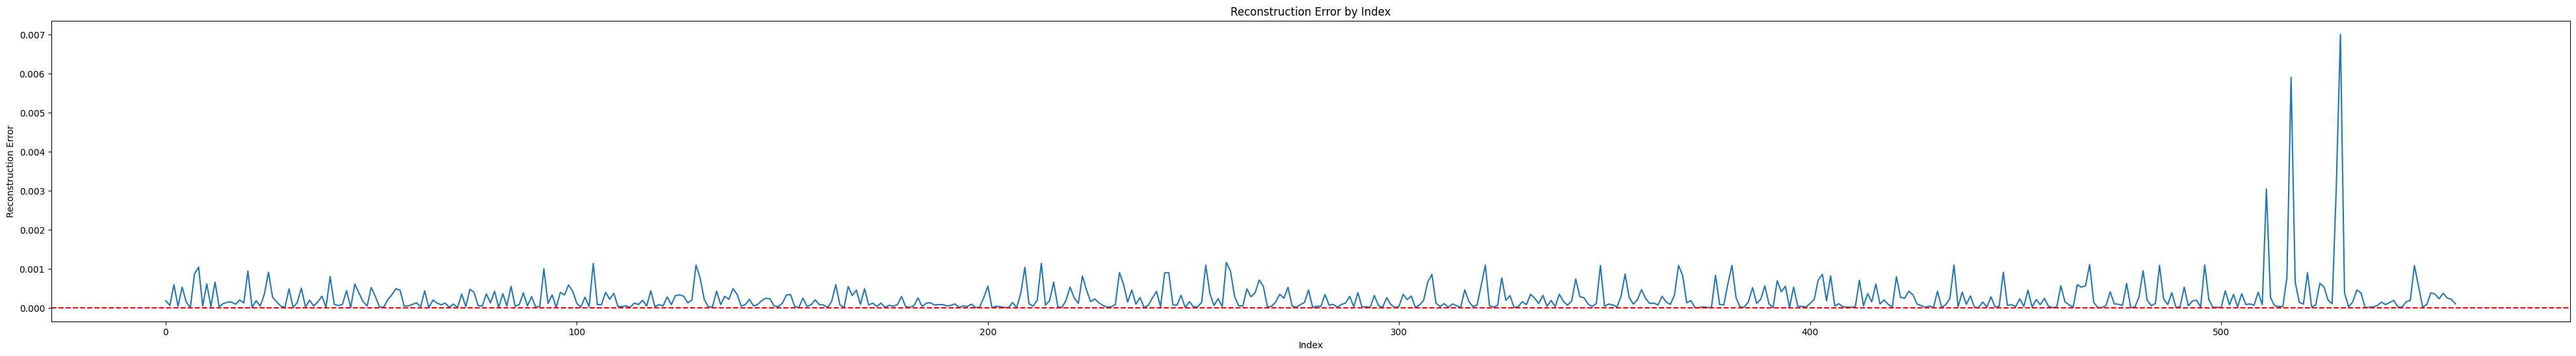

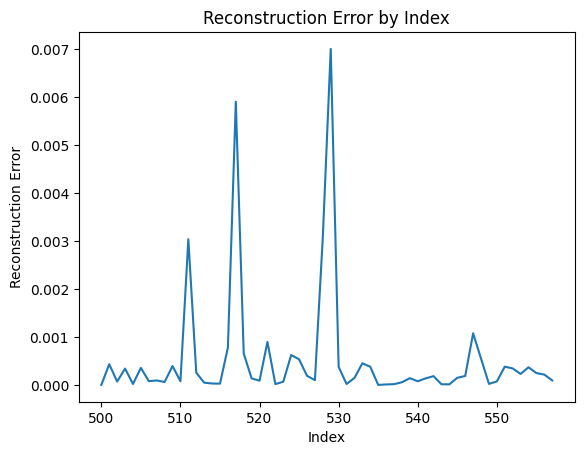

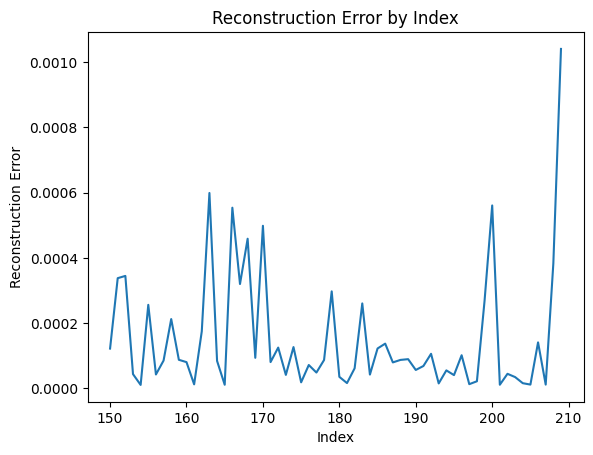

In [108]:
# 인덱스별 reconstruction_error 값을 그래프로 그립니다.
plt.figure(figsize=(50,6))
plt.plot(range(len(reconstruction_error)), reconstruction_error.detach().numpy())
plt.axhline(y=4.134245656928215e-08, color='r', linestyle='--')
plt.title("Reconstruction Error by Index")
plt.xlabel("Index")
plt.ylabel("Reconstruction Error")
plt.show()


# 인덱스 범위를 설정하여 reconstruction_error 값을 그래프로 그립니다.
start_index = 500
end_index = 558
plt.plot(range(start_index, end_index), reconstruction_error[start_index:end_index].detach().numpy())
# plt.axhline(y=4.134245656928215e-08, color='r', linestyle='--')
plt.title("Reconstruction Error by Index")
plt.xlabel("Index")
plt.ylabel("Reconstruction Error")
plt.show()

# 인덱스 범위를 설정하여 reconstruction_error 값을 그래프로 그립니다.
start_index = 150
end_index = 210
plt.plot(range(start_index, end_index), reconstruction_error[start_index:end_index].detach().numpy())
# plt.axhline(y=4.134245656928215e-08, color='r', linestyle='--')
plt.title("Reconstruction Error by Index")
plt.xlabel("Index")
plt.ylabel("Reconstruction Error")
plt.show()

In [ ]:
start_idx = 179
end_idx = 198
reconstruction_error_mean = torch.mean(reconstruction_error[start_idx:end_idx+1])

x = float(reconstruction_error_mean)
x

9.121890616370365e-05

In [ ]:
start_idx = 0
end_idx = 500
reconstruction_error_mean = torch.max(reconstruction_error[start_idx:end_idx+1])

x = float(reconstruction_error_mean)
x

0.0026305695064365864

In [ ]:
# Set a threshold for considering a test point as an anomaly
threshold = np.percentile(reconstruction_error.detach().numpy(), 99.6)
threshold

0.002623716554604472

In [ ]:
# Predict anomalies in test_data
test_prediction7 = (reconstruction_error.detach().numpy() > threshold).astype(int)

### 히든레이어 추가

In [67]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(new_train_data7)
test_data_scaled = scaler.transform(test_data7)

In [68]:
input_dim = train_data_scaled.shape[1]
encoding_dim = 64
hidden_dim = 32
hidden_dim_2 = 16

In [69]:
class Encoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, hidden_dim,hidden_dim_2):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, encoding_dim, bias = False)
        self.fc1 = nn.Linear(input_dim, encoding_dim)
        self.fc2 = nn.Linear(encoding_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim_2)
        #self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

class Decoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, hidden_dim, hidden_dim_2):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(hidden_dim_2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, encoding_dim)
        self.fc3 = nn.Linear(encoding_dim, input_dim)
        #self.fc4 = nn.Linear(encoding_dim, input_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

encoder = Encoder(input_dim, encoding_dim, hidden_dim, hidden_dim_2)
decoder = Decoder(input_dim, encoding_dim, hidden_dim, hidden_dim_2)
autoencoder_h2 = nn.Sequential(encoder, decoder)

In [70]:
print(autoencoder_h2)

Sequential(
  (0): Encoder(
    (fc1): Linear(in_features=10, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=16, bias=True)
  )
  (1): Decoder(
    (fc1): Linear(in_features=16, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [64]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters())

In [71]:
# Train the autoencoder with early stopping
epochs = 500
batch_size = 8
early_stopping_patience = 5
train_data_scaled_tensor = torch.tensor(train_data_scaled, dtype=torch.float32)
train_data_loader = torch.utils.data.DataLoader(train_data_scaled_tensor, batch_size=batch_size, shuffle=False)

min_val_loss = float('inf')
patience_count = 0
for epoch in range(epochs):
    running_loss = 0.0
    for data in train_data_loader:
        optimizer.zero_grad()
        outputs = autoencoder(data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    val_loss = criterion(autoencoder(torch.tensor(test_data_scaled, dtype=torch.float32)), torch.tensor(test_data_scaled, dtype=torch.float32)).item()
    print('epoch=', epoch, 'val_loss= ', val_loss)
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        patience_count = 0
    else:
        patience_count += 1
    if patience_count == early_stopping_patience:
        print(f"Early stopping at epoch {epoch}")
        break

epoch= 0 val_loss=  0.0004241732822265476
epoch= 1 val_loss=  0.00025246600853279233
epoch= 2 val_loss=  0.0002804491959977895
epoch= 3 val_loss=  0.006482195574790239
epoch= 4 val_loss=  0.0007660012925043702
epoch= 5 val_loss=  0.00024036946706473827
epoch= 6 val_loss=  0.001660542213357985
epoch= 7 val_loss=  0.00021954809199087322
epoch= 8 val_loss=  0.00020209859940223396
epoch= 9 val_loss=  0.000948950881138444
epoch= 10 val_loss=  0.00013883243082091212
epoch= 11 val_loss=  0.0019936440512537956
epoch= 12 val_loss=  0.00012583511124830693
epoch= 13 val_loss=  0.0004342207685112953
epoch= 14 val_loss=  0.00011741971684386954
epoch= 15 val_loss=  0.0005197893478907645
epoch= 16 val_loss=  0.00018588549573905766
epoch= 17 val_loss=  0.000150673309690319
epoch= 18 val_loss=  0.0012883085291832685
epoch= 19 val_loss=  0.00020616794063244015
Early stopping at epoch 19


In [73]:
# Calculate the reconstruction error for test_data
test_data_reconstructed = autoencoder(torch.tensor(test_data_scaled, dtype=torch.float32)).detach().numpy()

In [75]:
reconstruction_error = ((test_data_scaled - test_data_reconstructed) ** 2).mean(axis=1)

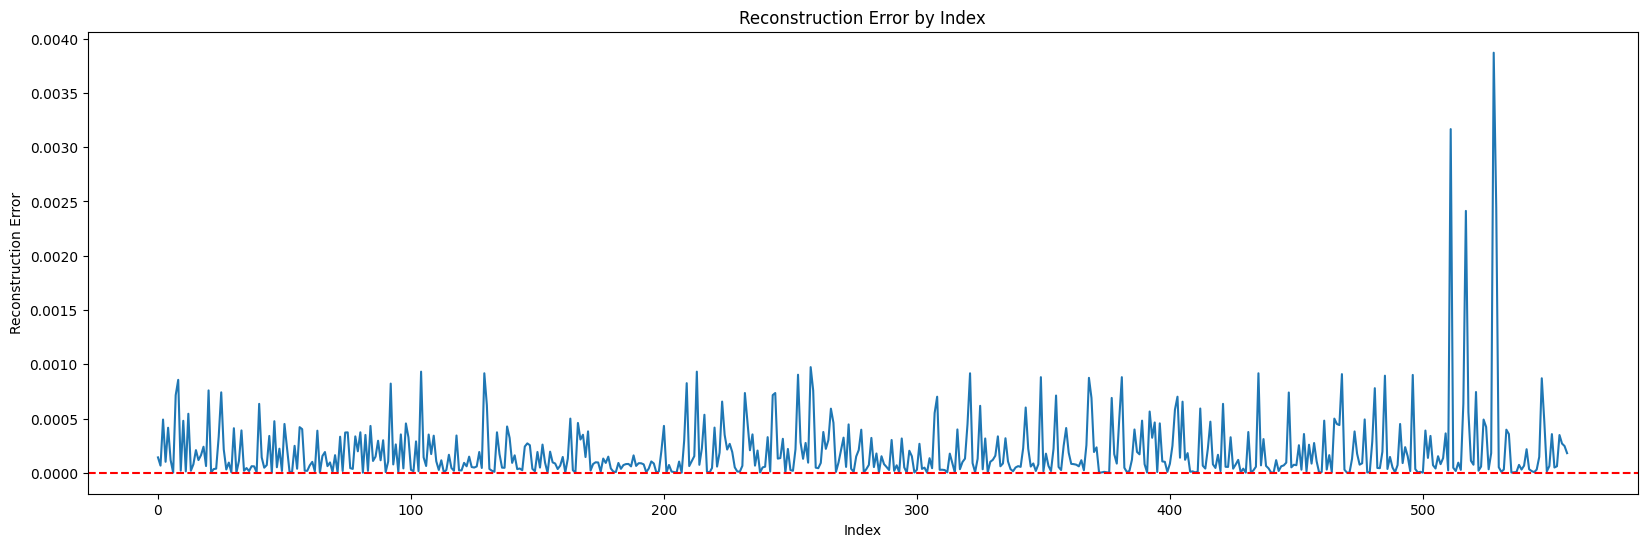

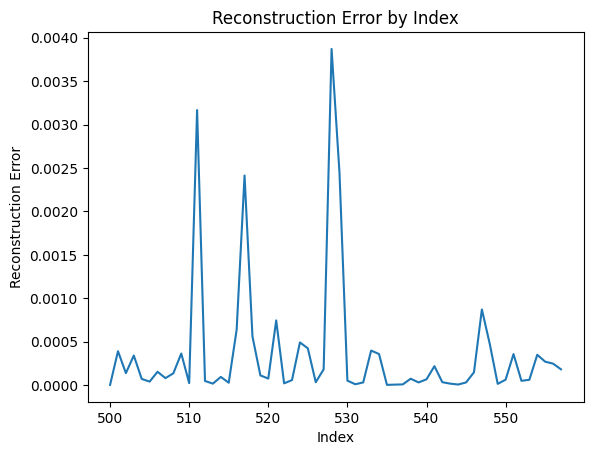

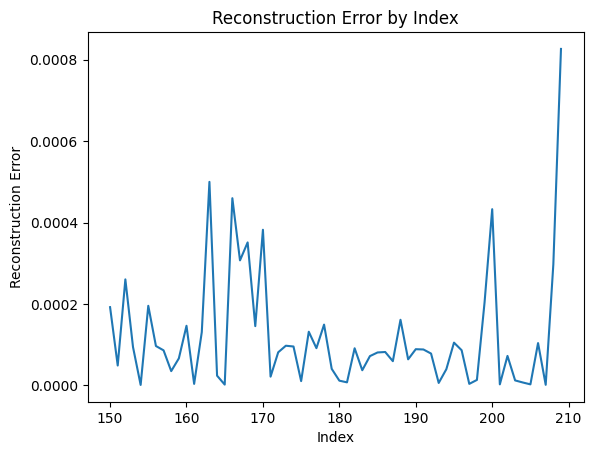

In [79]:
# 인덱스별 reconstruction_error 값을 그래프로 그립니다.
plt.figure(figsize=(20,6))
plt.plot(range(len(reconstruction_error)), reconstruction_error)
plt.axhline(y=4.134245656928215e-08, color='r', linestyle='--')
plt.title("Reconstruction Error by Index")
plt.xlabel("Index")
plt.ylabel("Reconstruction Error")
plt.show()


# 인덱스 범위를 설정하여 reconstruction_error 값을 그래프로 그립니다.
start_index = 500
end_index = 558
plt.plot(range(start_index, end_index), reconstruction_error[start_index:end_index])
# plt.axhline(y=4.134245656928215e-08, color='r', linestyle='--')
plt.title("Reconstruction Error by Index")
plt.xlabel("Index")
plt.ylabel("Reconstruction Error")
plt.show()

# 인덱스 범위를 설정하여 reconstruction_error 값을 그래프로 그립니다.
start_index = 150
end_index = 210
plt.plot(range(start_index, end_index), reconstruction_error[start_index:end_index])
# plt.axhline(y=4.134245656928215e-08, color='r', linestyle='--')
plt.title("Reconstruction Error by Index")
plt.xlabel("Index")
plt.ylabel("Reconstruction Error")
plt.show()

# 데이터 저장

In [ ]:
from collections import Counter

count = Counter(test_prediction7)
num_0 = count[0]
num_1 = count[1]

print("Number of 0s: ", num_0)
print("Number of 1s: ", num_1)

Number of 0s:  555
Number of 1s:  3


In [ ]:
file_name = model_name + '_th996'

In [ ]:
# 코랩에 저장
idx = test_data7.loc[:, 'type']
y_pred = {'type': idx, 'label': test_prediction7}
test_prediction = pd.DataFrame(y_pred)
test_prediction.to_csv(f"{file_name}.csv")

In [ ]:
# 구글드라이브에 저장(연동 필요요)
idx = test_data.loc[:, 'type']
y_pred = {'type': idx, 'label': prediction}
test_prediction = pd.DataFrame(y_pred)
test_prediction.to_csv(f"/content/drive/MyDrive/AIFactory/dataset/{file_name}.csv")